# Trabalho Prático 02 - Algoritmos para o problema do Caixeiro Viajante

- __Aluno__: Thiago Martin Poppe
- __Matrícula__: 2017014324

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from time import time
from math import ceil
from queue import PriorityQueue

### Variáveis que habilitam a geração de arquivos de análise

In [2]:
create_data_csv = False
create_metrics_csv = False

### Função para gerar pontos aleatórios

In [3]:
def generate_points(lower=0, upper=100, size=4):
    """
        Função que gera pontos com coordenadas inteiras em R²
        
        Parâmetros:
        ----------
        lower : int (opcional)
            O menor valor que pode ser gerado pelo gerador (por padrão é 0)
            
        upper : int (opcional)
            O maior valor que pode ser gerado pelo gerador (por padrão é 10)
            
        size : int (opcional)
            Número de pontos a serem gerados. Iremos gerar 2^size pontos, onde size
            deve ser um valor no intervalo [4, 10] (por padrão é 4)
            
        Retorno:
        -------
        Caso o valor de size seja inviável, a função retornará None. Senão, retornará uma
        lista de pontos com coordenadas inteiras em R²   
    """
    
    # Verificando se o parâmetro size é viável
    if size < 4 or size > 10:
        print('*** O parâmetro size deve ter valor entre [4, 10] ***')
        return None
    
    # Gerando 2**size pontos inteiros
    points = []
    for i in range(2**size):
        p = np.random.randint(lower, upper, 2)
        points.append(p)
        
    return points

### Função que calcula a distância euclidiana entre pontos

In [4]:
def get_euclidian_distance(points):
    """
        Função que calcula a distância euclidiana entre todos os pontos
        
        Parâmetros:
        ----------
        points : list of numpy.ndarray
            Lista contendo os pontos no plano R²
            
        Retorno:
        -------
        A função retorna uma lista de tuplas, onde o primeiro e segundo elementos são
        os vértices e o terceiro a distância calculada entre os mesmos usando a distância
        euclidiana
    """
    
    edges = []
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            dist = np.linalg.norm(points[i] - points[j])
            edges.append((i, j, dist))
            
    return edges

### Função que calcula a distância de manhattan entre pontos

In [5]:
def get_manhattan_distance(points):
    """
        Função que calcula a distância manhattan entre todos os pontos
        
        Parâmetros:
        ----------
        points : list of numpy.ndarray
            Lista contendo os pontos no plano R²
            
        Retorno:
        -------
        A função retorna uma lista de tuplas, onde o primeiro e segundo elementos são
        os vértices e o terceiro a distância calculada entre os mesmos usando a distância
        manhattan
    """
    
    edges = []
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            dist = np.abs(points[i] - points[j]).sum()
            edges.append((i, j, dist))
            
    return edges

### Função que realiza a estimação (bound) para o branch and bound

In [6]:
def bound(G, nodes):
    """
        Função para computar o bound para o algoritmo Branch and Bound
        
        Parâmetros:
        ----------
        G : grafo
            Grafo de entrada para o problema
            
        edges : list of tuple
            Lista de arestas que devem ter na nossa solução atual
            
        Retorno:
        -------
            Retorna o valor de bound para um nó na árvore do Branch and Bound  
    """
    
    # Convertendo a lista de vértices em listas de arestas
    edges = [(nodes[i], nodes[i+1]) for i in range(len(nodes)-1)]
    
    # Computando os pesos que devem ter na solução atual
    estimative = 0
    for (u, v) in edges:
        estimative += (2 * G[u][v]['weight'])
    
    for u in G.nodes():          
        # Encontrando as arestas que devem existir incidentes à 'u' 
        u_edges = list(filter(lambda x: x[0] == u or x[1] == u, edges))
        
        # Se tivermos 2 arestas podemos continuar para o próximo vértice
        if len(u_edges) < 2:
            # Computando os dois menores pesos das arestas que incidem àquele vértice
            u_data = list(G.edges(u, data=True))
            u_data = sorted(u_data, key=lambda x: x[2]['weight'])
            w1, w2 = u_data[0][2]['weight'], u_data[1][2]['weight']
            
            # Caso não tenhamos nenhuma aresta necessária, podemos somar os dois pesos
            if len(u_edges) == 0:
                estimative += w1
                estimative += w2
            
            # Senão somamos um dos dois pesos (não somando o mesmo peso da aresta duas vezes)
            elif len(u_edges) == 1:
                u, v = u_edges[0]
                must_have_weight = G[u][v]['weight']
                estimative += w1 if w1 < must_have_weight else w2
    
    return ceil(estimative / 2)

### Implementação do algoritmo de branch and bound

In [7]:
class Node:
    """
        Classe para representar um nó na árvore do Branch and Bound
    """
    
    def __init__(self, bound, level, cost, sol):
        self.bound = bound
        self.level = level
        self.cost = cost
        self.sol = sol
    
    # Comparação entre Nodes
    def __lt__(self, other):
        return self.bound < other.bound
    
    # Apenas para fins de debug
    def __str__(self):
        return 'bound: {}, level: {}, cost: {}, sol: {}'.format(self.bound, self.level, self.cost, self.sol)

def branch_and_bound(graph, time_limit=None):
    """ 
        Função que implementa o algoritmo Branch and Bound para o problema do TSP

        Parâmetros:
        ----------
        graph : grafo
            Grafo de entrada para o problema
            
        time_limit : int (opcional)
            Valor em segundos que irá ditar por quanto tempo o código ficará rodando (por padrão
            é None, ou seja, o código irá executar até achar a solução ótima)

        Retorno:
        -------
        A função retorna a ordem dos vértices do melhor caminho, o seu tamanho, o tempo de execução e se
        o tempo limite foi ultrapassado ou não
    """

    # Copiando o grafo para evitar possíveis modificações não desejadas
    G = graph.copy()

    # Criando o primeiro nó da árvore do Branch and Bound
    root = Node(bound(G, []), 1, 0, [0])
    heap = PriorityQueue()
    heap.put(root)
    
    # Definindo o melhor como infinito, a solução como vazia e tempo extrapolado como falso
    best = np.inf
    solution = []
    time_exceeded = False
    
    # Marcando o tempo de início
    start = time()
    
    # Percorrendo o min-heap
    while not heap.empty():
        # Verificando se extrapolamos o tempo limite
        if time_limit is not None:
            if (time() - start) > time_limit:
                time_exceeded = True
                print('*** Time limit excedeed ***')
                break
        
        node = heap.get()

        # Caso cheguemos em uma folha, iremos verificar se a mesma é
        # melhor do que uma solução que já achamos
        if node.level == G.number_of_nodes():
            total_cost = node.cost + G[node.sol[-1]][0]['weight']
            if total_cost < best:
                best = total_cost
                solution = node.sol + [0]

        elif node.bound < best:
            if node.level < G.number_of_nodes():
                for k in range(G.number_of_nodes()):
                    v = node.sol[-1]
                    # Aprofundando o Node se 'k' não estiver na solução, existir a aresta (v, k) e bound (com 'k') melhor que o best
                    if k not in node.sol and G.has_edge(v, k):
                        new_sol = node.sol + [k]
                        estimative = bound(G, node.sol + [k]) 
                        if estimative < best:
                            new_cost = node.cost + G[v][k]['weight']
                            heap.put(Node(estimative, node.level+1, new_cost, new_sol))
                        
        
    return solution, best, time() - start, time_exceeded

### Implementação do algoritmo twice around the tree (2 aproximado)

In [8]:
def twice_around_the_tree(graph):
    """
        Função que implementa o algoritmo 2-aproximativo para o problema do TSP
        
        Parâmetros:
        ----------
        graph : grafo
            Grafo de entrada para o problema
            
        Retorno:
        -------
        A função retorna a ordem dos vértices do caminho aproximado, o seu tamanho e o tempo de execução
    """

    # Copiando o grafo para evitar possíveis modificações não desejadas
    G = graph.copy()
    
    # Marcando o tempo de início
    start = time()
    
    # Encontrando a árvore geradora mínima do grafo
    MST = nx.minimum_spanning_tree(G)
    
    # Caminhando em pré-ordem pela árvore usando o vértice 0 como raiz e fechando o ciclo
    # Hamiltoniano, conectando o vértice final ao inicial
    walk = list(nx.dfs_preorder_nodes(MST, source=0))
    walk.append(0)

    # Computando o tamanho do caminho encontrado
    length = 0
    for i in range(len(walk)-1):
        u, v = walk[i], walk[i+1]
        length += G[u][v]['weight']
    
    return walk, length, time() - start

### Implementação do algoritmo de Christofides (1.5 aproximado)

In [9]:
def christofides(graph):
    """
        Função que implementa o algoritmo 1.5-aproximativo para o problema do TSP
        
        Parâmetros:
        ----------
        graph : grafo
            Grafo de entrada para o problema
            
        time_limit : int (opcional)
            Valor em segundos que irá ditar por quanto tempo o código ficará rodando (por padrão
            é None, ou seja, o código irá executar até achar a solução ótima)
            
        Retorno:
        -------
        A função retorna a ordem dos vértices do caminho aproximado, o seu tamanho e o tempo de execução
    """
    
    # Copiando o grafo para evitar possíveis modificações não desejadas
    G = graph.copy()

    # Marcando o tempo de início
    start = time()
    
    # Encontrando a árvore geradora mínima do grafo
    MST = nx.minimum_spanning_tree(G)
    
    # Criando o conjunto de vértices que possuem grau ímpar e montando um subgrafo induzido a partir dos mesmos
    odd_degree_nodes = []
    for node in MST.nodes():
        if MST.degree(node) % 2 == 1:
            odd_degree_nodes.append(node)
    
    induced_graph = G.subgraph(odd_degree_nodes)
    
    # Invertendo o peso das arestas para computar o matching perfeito de peso mínimo a partir
    # do algoritmo de computar o de peso máximo
    for (u, v) in induced_graph.edges():
        induced_graph[u][v]['weight'] *= -1
        
    # Encontrando o matching perfeito de peso mínimo e voltando os pesos para o original
    min_weight_matching = nx.max_weight_matching(induced_graph, maxcardinality=True)
    
    # Criando um subgrafo induzido com as arestas do matching perfeito de peso mínimo
    min_weight_matching_graph = G.edge_subgraph(min_weight_matching)
    
    # Criando um multigrafo com os vértices de G e arestas da MST e do matching perfeito de peso mínimo
    multigraph = nx.MultiGraph()
    multigraph.add_weighted_edges_from(MST.edges.data('weight'))
    multigraph.add_weighted_edges_from(min_weight_matching_graph.edges.data('weight'))
    
    # Computando o circuito euleriano
    eulerian_circuit = [u for (u, v) in nx.eulerian_circuit(multigraph, source=0)]
    
    # Retirando vértices repetidos, construindo assim um circuito hamiltoniano
    walk = []
    for node in eulerian_circuit:
        if node not in walk:
            walk.append(node)
    
    walk.append(0)
    
    # Computando o tamanho do caminho encontrado
    length = 0
    for i in range(len(walk)-1):
        u, v = walk[i], walk[i+1]
        length += graph[u][v]['weight']
        
    return walk, length, time() - start

### Teste 01

In [10]:
# Exemplo tirado do site: https://www.brainkart.com/article/Approximation-Algorithms-for-the-Traveling-Salesman-Problem_8065/
edges = [
    (0, 1, 4),
    (0, 2, 8),
    (0, 3, 9),
    (0, 4, 12),
    
    (1, 2, 6),
    (1, 3, 8),
    (1, 4, 9),
    
    (2, 3, 10),
    (2, 4, 11),
    
    (3, 4, 7)
]

G = nx.Graph()
G.add_weighted_edges_from(edges)

sol, val, _, _ = branch_and_bound(G)
print('Branch and bound solution:', sol)
print('Branch and bound final cost:', val)

sol, val, _ = twice_around_the_tree(G)
print('\nTwice around the tree solution:', sol)
print('Twice around the tree final cost:', val)

sol, val, _ = christofides(G)
print('\nChristofides solution:', sol)
print('Christofides final cost:', val)

Branch and bound solution: [0, 1, 2, 4, 3, 0]
Branch and bound final cost: 37

Twice around the tree solution: [0, 1, 2, 3, 4, 0]
Twice around the tree final cost: 39

Christofides solution: [0, 1, 3, 4, 2, 0]
Christofides final cost: 38


### Teste 02

In [11]:
# Exemplo tirado do Wikipédia: https://en.wikipedia.org/wiki/Christofides_algorithm
edges = [
    (0, 1, 1),
    (0, 2, 1),
    (0, 3, 2),
    (0, 4, 1),
    
    (1, 2, 2),
    (1, 3, 1),
    (1, 4, 1),
    
    (2, 3, 1),
    (2, 4, 1),
    
    (3, 4, 1)
]

G = nx.Graph()
G.add_weighted_edges_from(edges)

sol, val, _, _ = branch_and_bound(G)
print('Branch and bound solution:', sol)
print('Branch and bound final cost:', val)

sol, val, _ = twice_around_the_tree(G)
print('\nTwice around the tree solution:', sol)
print('Twice around the tree final cost:', val)

sol, val, _ = christofides(G)
print('\nChristofides solution:', sol)
print('Christofides final cost:', val)

Branch and bound solution: [0, 1, 3, 2, 4, 0]
Branch and bound final cost: 5

Twice around the tree solution: [0, 1, 3, 2, 4, 0]
Twice around the tree final cost: 5

Christofides solution: [0, 2, 4, 3, 1, 0]
Christofides final cost: 5


### Teste 03

In [12]:
# Exemplo tirado do slide
edges = [
    (0, 1, 3),
    (0, 2, 1),
    (0, 3, 5),
    (0, 4, 8),
    
    (1, 2, 6),
    (1, 3, 7),
    (1, 4, 9),
    
    (2, 3, 4),
    (2, 4, 2),
    
    (3, 4, 3)
]

G = nx.Graph()
G.add_weighted_edges_from(edges)

sol, val, _, _ = branch_and_bound(G)
print('Branch and bound solution:', sol)
print('Branch and bound final cost:', val)

sol, val, _ = twice_around_the_tree(G)
print('\nTwice around the tree solution:', sol)
print('Twice around the tree final cost:', val)

sol, val, _ = christofides(G)
print('\nChristofides solution:', sol)
print('Christofides final cost:', val)

Branch and bound solution: [0, 2, 4, 3, 1, 0]
Branch and bound final cost: 16

Twice around the tree solution: [0, 2, 4, 3, 1, 0]
Twice around the tree final cost: 16

Christofides solution: [0, 1, 3, 4, 2, 0]
Christofides final cost: 16


### Criando dados para análise (comparação de algoritmos)

- Essa célula roda em torno de 5 horas para gerar todos os dados necessários. Sendo assim, apenas execute a mesma caso queira gerá-los.

In [13]:
# Verificando se queremos criar o arquivo data.csv
if create_data_csv == True:
    
    # Abrindo o arquivo .csv para escrita
    with open('data.csv', 'a') as csvFile:
        # Escrevendo o cabeçalho (comentado para não gerar erros no .csv)
#         print('size,algorithm,type,length,time,exceeded', file=csvFile)

        # Criando instâncias e salvando no csv
        for i in range(4, 11):
            print('Criando instância de tamanho 2^{}'.format(i))
            pts = generate_points(size=i)

            edges = get_euclidian_distance(pts)
            G = nx.Graph()
            G.add_weighted_edges_from(edges)

            
            # --- Resultados para distância euclidiana --- #
            print('Resolvendo para distância euclidiana (BnB)')
            _, length, t, exceeded = branch_and_bound(G, time_limit=1200)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(2**i, 'BnB', 'euclidian', length, t, exceeded), file=csvFile)

            print('Resolvendo para distância euclidiana (Twice)')
            _, length, t = twice_around_the_tree(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(2**i, 'Twice', 'euclidian', length, t, False), file=csvFile)

            print('Resolvendo para distância euclidiana (Christofides)')
            _, length, t = christofides(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(2**i, 'Christofides', 'euclidian', length, t, False), file=csvFile)

            edges = get_manhattan_distance(pts)
            G = nx.Graph()
            G.add_weighted_edges_from(edges)

            # --- Resultados para distância de manhattan --- #
            print('Resolvendo para distância manhattan (BnB)')
            _, length, t, exceeded = branch_and_bound(G, time_limit=1200)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(2**i, 'BnB', 'manhattan', length, t, exceeded), file=csvFile)

            print('Resolvendo para distância manhattan (Twice)')
            _, length, t = twice_around_the_tree(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(2**i, 'Twice', 'manhattan', length, t, False), file=csvFile)

            print('Resolvendo para distância manhattan (Christofides)')
            _, length, t = christofides(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(2**i, 'Christofides', 'manhattan', length, t, False), file=csvFile)

### Lendo os dados com pandas

In [14]:
df = pd.read_csv('tables/data.csv')
df

,size,algorithm,type,length,time,exceeded
0,16,BnB,euclidian,377.557079,457.374122,False
1,16,Twice,euclidian,467.394701,0.001994,False
2,16,Christofides,euclidian,425.247028,0.021941,False
3,16,BnB,manhattan,462.000000,204.791420,False
4,16,Twice,manhattan,562.000000,0.002010,False
5,16,Christofides,manhattan,518.000000,0.010982,False
6,32,BnB,euclidian,inf,1200.034463,True
7,32,Twice,euclidian,478.133068,0.005015,False
8,32,Christofides,euclidian,419.378881,0.045872,False
9,32,BnB,manhattan,inf,1200.011399,True


### Limpando as linhas cujo tempo foi excedido

In [15]:
df_clean = df.loc[df['exceeded'] == False]
print('Size of original df:', len(df))
print('Size of cleaned df:', len(df_clean))

df_clean

Size of original df: 42
Size of cleaned df: 30


,size,algorithm,type,length,time,exceeded
0,16,BnB,euclidian,377.557079,457.374122,False
1,16,Twice,euclidian,467.394701,0.001994,False
2,16,Christofides,euclidian,425.247028,0.021941,False
3,16,BnB,manhattan,462.000000,204.791420,False
4,16,Twice,manhattan,562.000000,0.002010,False
5,16,Christofides,manhattan,518.000000,0.010982,False
7,32,Twice,euclidian,478.133068,0.005015,False
8,32,Christofides,euclidian,419.378881,0.045872,False
10,32,Twice,manhattan,604.000000,0.004987,False
11,32,Christofides,manhattan,530.000000,0.039938,False


- Percebemos pela limpeza acima que todas as instâncias do branch and bound com a coluna $size >= 2^5$ resultou em tempo limite excedido. Continuaremos a análise com esses dados apenas, voltando mais pra frente para o branch and bound rodando instâncias de tamanho $2^4$ apenas.

### Análise temporal dos dados com distância euclidiana

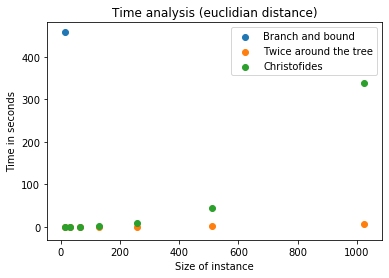

In [16]:
# Extraindo apenas os dados cuja distância usada foi a euclidiana
df_euclid = df_clean.loc[df_clean['type'] == 'euclidian']

# Extraindo os tempos gastos por cada algoritmo
bnb_time = df_euclid.loc[df_euclid['algorithm'] == 'BnB']['time'].to_list()
twice_time = df_euclid.loc[df_euclid['algorithm'] == 'Twice']['time'].to_list()
christofides_time = df_euclid.loc[df_euclid['algorithm'] == 'Christofides']['time'].to_list()

# Definindo parâmetros do plot
plt.title('Time analysis (euclidian distance)')
plt.xlabel('Size of instance')
plt.ylabel('Time in seconds')

# Definindo o eixo x
x_bnb = [2**i for i in range(4, 4+len(bnb_time))]
x_twice = [2**i for i in range(4, 4+len(twice_time))]
x_christofides = [2**i for i in range(4, 4+len(christofides_time))]

# Plotando os dados
plt.scatter(x_bnb, bnb_time, label='Branch and bound')
plt.scatter(x_twice, twice_time, label='Twice around the tree')
plt.scatter(x_christofides, christofides_time, label='Christofides')

# Exibindo os dados
plt.legend()
plt.show()

- Percebemos pelo plot acima, que Twice around the tree $\prec$ Christofides $\prec$ Branch and bound, no que tange a complexidade assintótica ao analisarmos o tamanho das instâncias.

- Isso condiz com o que esperavamos, visto que, o algoritmo twice around the tree possui complexidade assintótica temporal da ordem de $O((|V| + |E|) log(|V|))$, pois o mesmo é dominado assintóticamente pelo custo de encontrar a árvore geradora mínima. Como foi implementado usando o algoritmo de Prim (https://www.hackerearth.com/pt-br/practice/algorithms/graphs/minimum-spanning-tree/tutorial/), o mesmo possui a sua complexidade. Já para algoritmo de Christofides, possuimos complexidade assintótica temporal da ordem de $O(|V|^3)$, visto que, o mesmo é dominado assintóticamente pelo custo de encontrar o matching perfeito de peso mínimo, que foi implementado usando uma adaptação do algoritmo de Blossom presente na biblioteca Networkx, usado para achar o de peso máximo (https://brilliant.org/wiki/blossom-algorithm/). Para finalizar, o algoritmo branch and bound foi o que teve maior tempo de execução dos três, sendo que para as instâncias com tamanho maior ou igual a $2^5$ o algoritmo se quer conseguiu concluir em menos de 20 minutos. Isso era de se esperar, visto que o mesmo realiza uma busca exaustiva sobre a árvore de possibilidades, resultando assim em um custo assintótico $O(2^{|V|})$.

### Analise temporal dos dados com distância de manhattan

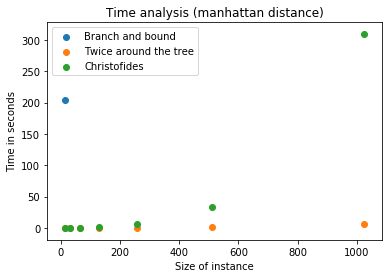

In [17]:
# Extraindo apenas os dados cuja distância usada foi a de manhattan
df_manhattan = df_clean.loc[df_clean['type'] == 'manhattan']

# Extraindo os tempos gastos por cada algoritmo
bnb_time = df_manhattan.loc[df_manhattan['algorithm'] == 'BnB']['time'].to_list()
twice_time = df_manhattan.loc[df_manhattan['algorithm'] == 'Twice']['time'].to_list()
christofides_time = df_manhattan.loc[df_manhattan['algorithm'] == 'Christofides']['time'].to_list()

# Definindo parâmetros do plot
plt.title('Time analysis (manhattan distance)')
plt.xlabel('Size of instance')
plt.ylabel('Time in seconds')

# Definindo o eixo x
x_bnb = [2**i for i in range(4, 4+len(bnb_time))]
x_twice = [2**i for i in range(4, 4+len(twice_time))]
x_christofides = [2**i for i in range(4, 4+len(christofides_time))]

# Plotando os dados
plt.scatter(x_bnb, bnb_time, label='Branch and bound')
plt.scatter(x_twice, twice_time, label='Twice around the tree')
plt.scatter(x_christofides, christofides_time, label='Christofides')

# Exibindo os dados
plt.legend()
plt.show()

- Podemos perceber a ordem que foi relatada ao analisarmos para a distância euclidiana. Porém, aqui podemos perceber que o tempo gasto para resolver as instâncias foi menor do que antes.

- Vale ressaltar o tempo gasto pelo branch and bound para resolver os problemas. Ainda temos um caso onde o algoritmo só consegue resolver a instância de tamanho $2^4$ em menos de 20 minutos, porém, conseguimos ver que o tempo caiu de $\approx460$ segundos para $\approx200$ segundos.

- Não podemos concluir ainda que a distância de manhattan garante um tempo de execução menor, visto que, o algoritmo de branch and bound caminha pela árvore de possibilidades atráves de heurísticas, por exemplo, em nossa implementação, escolhemos sempre o subproblema de menor bound para resolver (abordagem depth-first search). Sendo assim, há casos onde o branch and bound irá resolver de forma bastante rápida o problema; já em outros irá demorar mais, pois a heurística realizada não foi suficiente para garantir um número considerável de podas na árvore.

### Criando dados para análise (comparação entre métricas)

- Iremos comparar o tempo gasto para resolver os problemas de tamanho $2^4$ usando diferentes métricas para as distâncias (euclidiana e manhattan), com o intuito de concluir se há alguma alteração considerável no tempo de execução.

- Escolhemos usar $2^4$ apenas para podermos analisar por parte do branch and bound também.

In [18]:
# Verificando se queremos criar o arquivo metrics.csv
if create_metrics_csv == True:
    
    # Abrindo o arquivo .csv para escrita
    with open('metrics.csv', 'a') as csvFile:
        # Escrevendo o cabeçalho (comentado para não gerar erro no .csv)
#         print('size,algorithm,type,length,time,exceeded', file=csvFile)

        # Criando instâncias e salvando no csv
        for i in range(10):
            print('Analisando instância {}'.format(i+1))
            pts = generate_points(size=4)

            edges = get_euclidian_distance(pts)
            G = nx.Graph()
            G.add_weighted_edges_from(edges)

            
            # --- Resultados para distância euclidiana --- #
            print('Resolvendo para distância euclidiana (BnB)')
            _, length, t, exceeded = branch_and_bound(G, time_limit=1200)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(16, 'BnB', 'euclidian', length, t, exceeded), file=csvFile)

            print('Resolvendo para distância euclidiana (Twice)')
            _, length, t = twice_around_the_tree(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(16, 'Twice', 'euclidian', length, t, False), file=csvFile)

            print('Resolvendo para distância euclidiana (Christofides)')
            _, length, t = christofides(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(16, 'Christofides', 'euclidian', length, t, False), file=csvFile)

            edges = get_manhattan_distance(pts)
            G = nx.Graph()
            G.add_weighted_edges_from(edges)

            # --- Resultados para distância de manhattan --- #
            print('Resolvendo para distância manhattan (BnB)')
            _, length, t, exceeded = branch_and_bound(G, time_limit=1200)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(16, 'BnB', 'manhattan', length, t, exceeded), file=csvFile)

            print('Resolvendo para distância manhattan (Twice)')
            _, length, t = twice_around_the_tree(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(16, 'Twice', 'manhattan', length, t, False), file=csvFile)

            print('Resolvendo para distância manhattan (Christofides)')
            _, length, t = christofides(G)
            print('Tempo:', t)
            print('{},{},{},{},{},{}'.format(16, 'Christofides', 'manhattan', length, t, False), file=csvFile)

### Lendo os dados com pandas

In [19]:
df = pd.read_csv('tables/metrics.csv')
df

,size,algorithm,type,length,time,exceeded
0,16,BnB,euclidian,354.730448,175.331548,False
1,16,Twice,euclidian,404.646972,0.002034,False
2,16,Christofides,euclidian,376.742388,0.010970,False
3,16,BnB,manhattan,448.000000,117.455265,False
4,16,Twice,manhattan,498.000000,0.001995,False
...,...,...,...,...,...,...
115,16,Twice,euclidian,420.098053,0.002004,False
116,16,Christofides,euclidian,383.537424,0.015910,False
117,16,BnB,manhattan,422.000000,14.995064,False
118,16,Twice,manhattan,616.000000,0.000990,False


### Limpando as linhas cujo tempo foi excedido

In [20]:
df_clean = df.loc[df['exceeded'] == False]
print('Size of original df:', len(df))
print('Size of cleaned df:', len(df_clean))

df_clean

Size of original df: 120
Size of cleaned df: 116


,size,algorithm,type,length,time,exceeded
0,16,BnB,euclidian,354.730448,175.331548,False
1,16,Twice,euclidian,404.646972,0.002034,False
2,16,Christofides,euclidian,376.742388,0.010970,False
3,16,BnB,manhattan,448.000000,117.455265,False
4,16,Twice,manhattan,498.000000,0.001995,False
...,...,...,...,...,...,...
115,16,Twice,euclidian,420.098053,0.002004,False
116,16,Christofides,euclidian,383.537424,0.015910,False
117,16,BnB,manhattan,422.000000,14.995064,False
118,16,Twice,manhattan,616.000000,0.000990,False


### Análise temporal dos dados com distância euclidiana

In [21]:
# Função auxiliar para retornar os tempos em um vetor numpy
def series_to_numpy_time(df, algorithm):
    return df[df['algorithm'] == algorithm]['time'].astype(np.float32).to_numpy()

# Extraindo apenas os dados cuja distância usada foi a euclidiana
df_euclid = df_clean.loc[df_clean['type'] == 'euclidian']

# Extraindo os tempos gastos por cada algoritmo
bnb_time = series_to_numpy_time(df_euclid, 'BnB')
twice_time = series_to_numpy_time(df_euclid, 'Twice')
christofides_time = series_to_numpy_time(df_euclid, 'Christofides')

# Exibindo a média e desvio padrão para os tempos de cada algoritmo
print('* Branch and bound:')
print('   -> Mean =', bnb_time.mean())
print('   -> Std  =', bnb_time.std(ddof=1))

print('\n* Twice around the tree:')
print('   -> Mean =', twice_time.mean())
print('   -> Std  =', twice_time.std(ddof=1))

print('\n* Christofides:')
print('   -> Mean =', christofides_time.mean())
print('   -> Std  =', christofides_time.std(ddof=1))

* Branch and bound:
   -> Mean = 215.62491
   -> Std  = 248.05705

* Twice around the tree:
   -> Mean = 0.001355648
   -> Std  = 0.0004960693

* Christofides:
   -> Mean = 0.010482252
   -> Std  = 0.0064137327


### Análise temporal dos dados com distância de manhattan

In [22]:
# Função auxiliar para retornar os tempos em um vetor numpy
def series_to_numpy_time(df, algorithm):
    return df[df['algorithm'] == algorithm]['time'].astype(np.float32).to_numpy()

# Extraindo apenas os dados cuja distância usada foi a de manhattan
df_manhattan = df_clean.loc[df_clean['type'] == 'manhattan']

# Extraindo os tempos gastos por cada algoritmo
bnb_time = series_to_numpy_time(df_manhattan, 'BnB')
twice_time = series_to_numpy_time(df_manhattan, 'Twice')
christofides_time = series_to_numpy_time(df_manhattan, 'Christofides')

# Exibindo a média e desvio padrão para os tempos de cada algoritmo
print('* Branch and bound:')
print('   -> Mean =', bnb_time.mean())
print('   -> Std  =', bnb_time.std(ddof=1))

print('\n* Twice around the tree:')
print('   -> Mean =', twice_time.mean())
print('   -> Std  =', twice_time.std(ddof=1))

print('\n* Christofides:')
print('   -> Mean =', christofides_time.mean())
print('   -> Std  =', christofides_time.std(ddof=1))

* Branch and bound:
   -> Mean = 200.34518
   -> Std  = 224.48376

* Twice around the tree:
   -> Mean = 0.0015483499
   -> Std  = 0.0006063993

* Christofides:
   -> Mean = 0.010517108
   -> Std  = 0.0057145683
